<a href="https://colab.research.google.com/github/raminazari/financial-model/blob/main/gonbad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


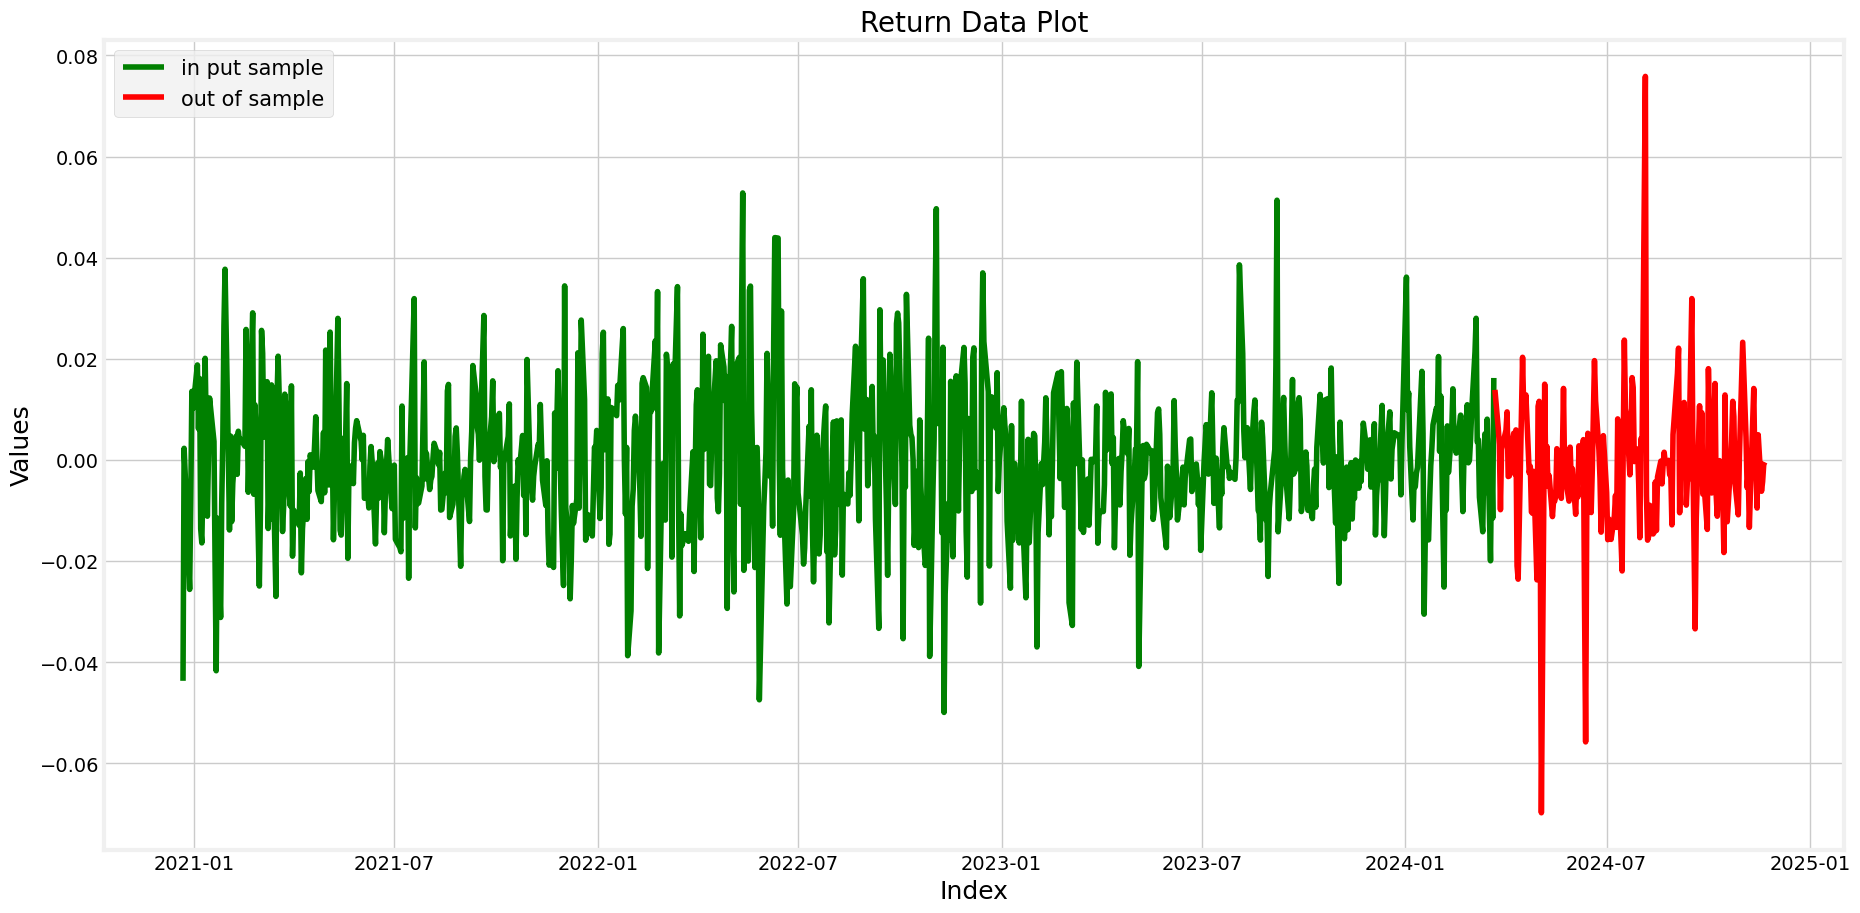

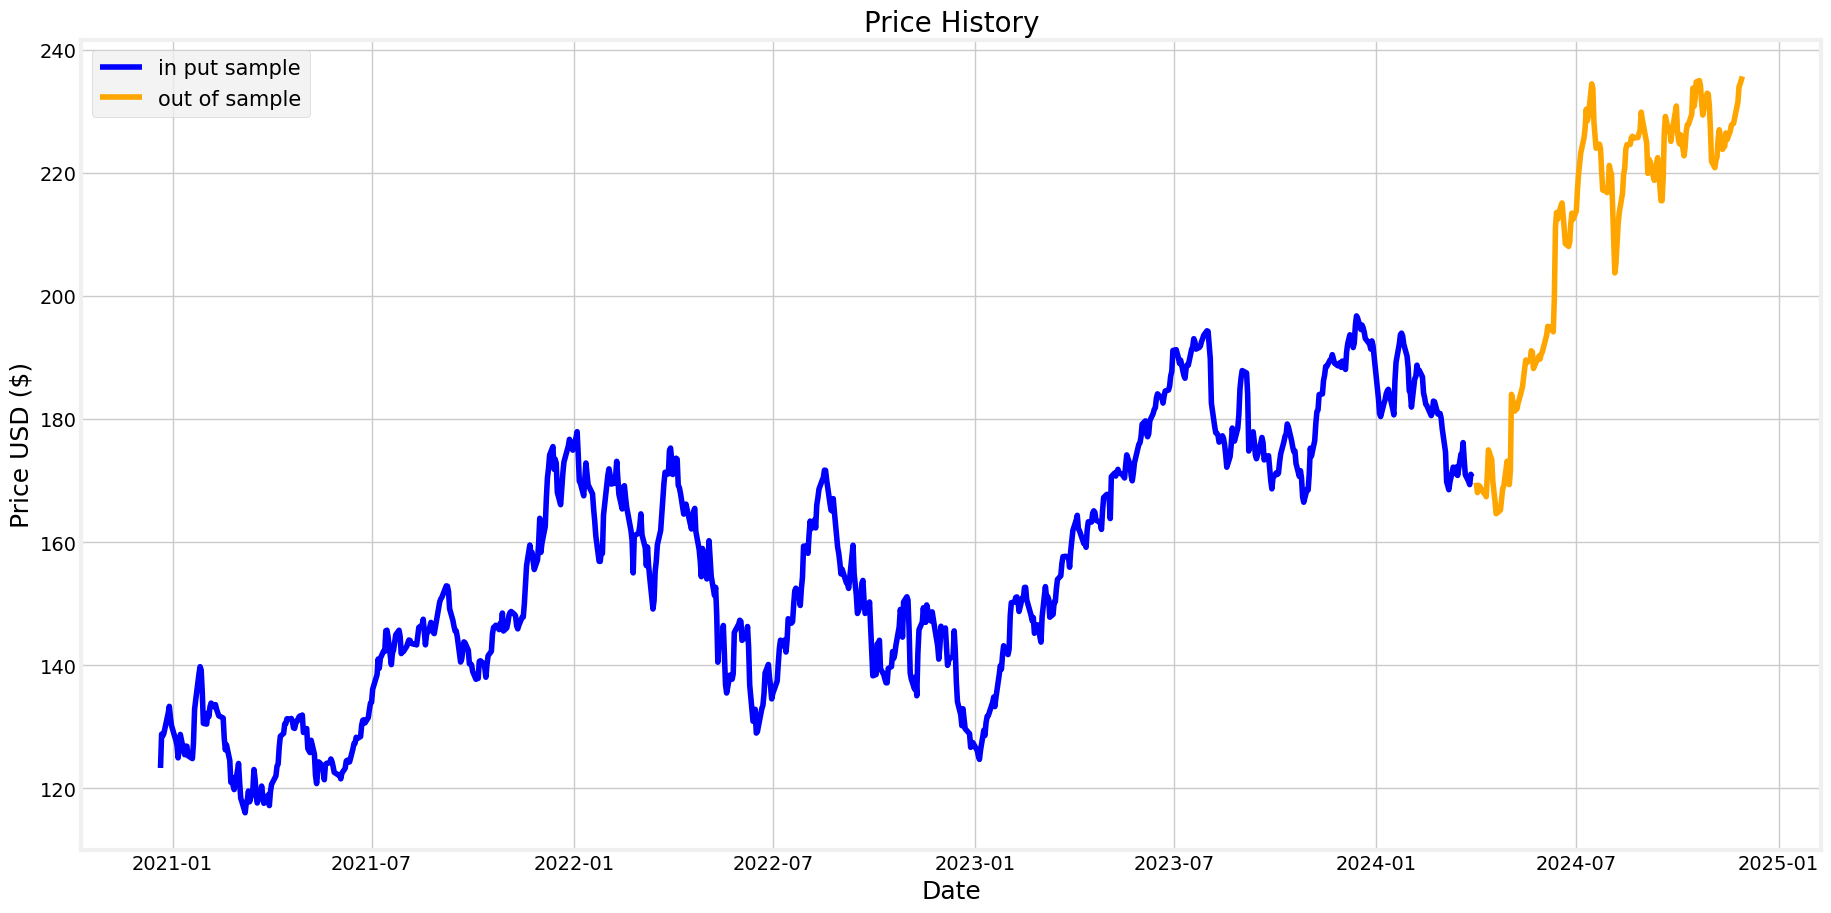

In [13]:
import math
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import yfinance as yf
from scipy.stats import shapiro, chi2
from keras.layers import Dense, GRU
from keras.models import Sequential
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from numpy import array

# دانلود داده‌های AAPL از Yahoo Finance
dataset = yf.download("AAPL", start="2020-12-20", end="2024-12-01")
data1 = pd.DataFrame(dataset)
data1.to_csv("data1.csv")

# محاسبه میانگین قیمت‌های روزانه
nf = 5
data = data1.head(len(data1))
datasetC = (data['Close'] + data['Open'] + data['High'] + data['Low']) / 4

# محاسبه بازده لگاریتمی
datar1 = ((np.log(datasetC.astype('float64').shift(+1))) - np.log(datasetC.astype('float64')))
datar = datar1.tail(len(datar1) - 1)

# تقسیم داده‌ها به داده‌های آموزشی و داده‌های واقعی برای پیش‌بینی
returndata = datar.head(len(datar) - nf)
realdataf = datar.tail(nf)

# رسم نمودار بازده‌ها
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
plt.plot(returndata.head(len(returndata) - 170), color='green', label='in put sample')
plt.plot(returndata.tail(170), color='red', label='out of sample')
plt.title('Return Data Plot', fontsize=20)
plt.xlabel('Index', fontsize=18)
plt.ylabel('Values', fontsize=18)
plt.legend(fontsize=15)
plt.grid(True)
plt.show()

# رسم نمودار تاریخچه قیمت
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
plt.plot(datasetC.head(len(datasetC) - 170), color='blue', label='in put sample')
plt.plot(datasetC.tail(170), color='orange', label='out of sample')
plt.title('Price History', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD ($)', fontsize=18)
plt.legend(fontsize=15)
plt.grid(True)
plt.show()



Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.0308e-04
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9674e-04 
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9131e-04
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7789e-04 
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.8456e-04
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7620e-04  
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9394e-04 
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8302e-04 
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.8874e-04
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8832e-04 
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8318e-04 
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7275e-04 
Epoch 13/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8588e-04 
Epoch 14/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8894e-04
Epoch 15/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 

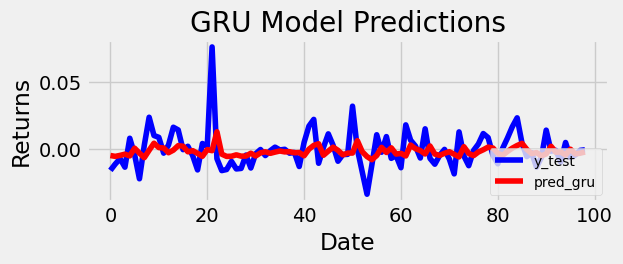

In [14]:
# تبدیل داده‌ها به فرمت supervised
def to_supervised(train, n_input, n_out):
    data = train
    X, y = list(), list()
    in_start = 0
    for _ in range(len(data)):
        in_end = in_start + n_input
        out_end = in_end + n_out
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input)))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        in_start += 1
    return array(X), array(y)

# تفاضل گیری از داده‌ها
def difference(returndata, interval=1):
    diff = list()
    for i in range(interval, len(returndata)):
        value = returndata[i] - returndata[i - interval]
        diff.append(value)
    return diff

# آماده‌سازی داده‌ها
dataset1 = np.array(returndata)
dataset_diff = difference(dataset1, 1)
dataset_diff = pd.DataFrame(dataset_diff)
dataset2 = np.array(returndata)
predreturn = np.reshape(dataset2, (dataset2.shape[0], 1))

# پارامترهای مدل
n_step = 1
lag = 1
X, y = to_supervised(predreturn, n_input=lag, n_out=n_step)

# تقسیم داده‌ها به داده‌های آموزشی و آزمون
split_percentage = 0.9
n_test = len(returndata) - int(split_percentage * len(returndata))
n_train = len(returndata) - n_test
x_train, x_test = X[:-n_test, :], X[-n_test:, :]
y_train, y_test = y[:-n_test, :], y[-n_test:, :]

# تغییر شکل داده‌ها برای GRU
x_train_reshaped = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test_reshaped = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# تعریف مدل GRU
model_gru = Sequential()
model_gru.add(GRU(64, activation='relu', input_shape=(x_train.shape[1], 1)))
model_gru.add(Dense(n_step, activation='selu'))
model_gru.compile(loss='mse', optimizer='adam')

# آموزش مدل
model_gru.fit(x_train_reshaped, y_train, epochs=100, batch_size=100)

# پیش‌بینی با مدل GRU
predict_gru = model_gru.predict(x_test_reshaped)

# محاسبه خطای MSE
mse_gru = mean_squared_error(y_test, predict_gru)
print("MSE for GRU model:", mse_gru)

# رسم نمودار پیش‌بینی‌ها
fig = plt.figure(figsize=(6, 2))
plt.plot(y_test, color='b', label='y_test')
plt.plot(predict_gru, color='r', label='pred_gru')
plt.legend(loc='lower right', fontsize=10)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('GRU Model Predictions')
plt.show()

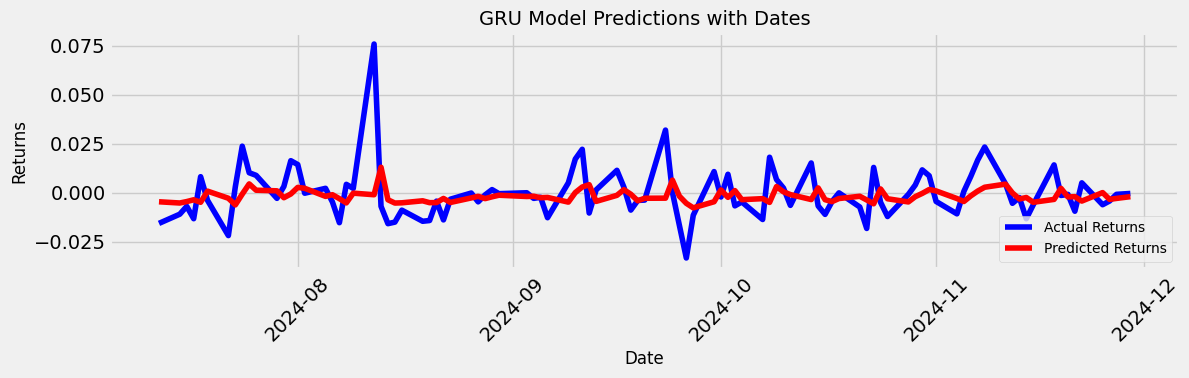

In [15]:

# فرض کنید y_test و predict_gru به همراه تاریخ‌های مربوطه هستند
# اگر y_test و predict_gru به صورت آرایه‌های numpy هستند، ابتدا آن‌ها را به DataFrame تبدیل می‌کنیم
import pandas as pd

# تبدیل y_test و predict_gru به DataFrame و اختصاص تاریخ‌ها به عنوان شاخص
dates = data1.index[-n_test:]  # تاریخ‌های مربوط به داده‌های آزمون
y_test_df = pd.DataFrame(y_test, index=dates, columns=['Returns'])
predict_gru_df = pd.DataFrame(predict_gru, index=dates, columns=['Predicted Returns'])

# رسم نمودار با تاریخ‌ها
plt.figure(figsize=(12, 4))
plt.plot(y_test_df.index, y_test_df['Returns'], color='b', label='Actual Returns')
plt.plot(predict_gru_df.index, predict_gru_df['Predicted Returns'], color='r', label='Predicted Returns')
plt.legend(loc='lower right', fontsize=10)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Returns', fontsize=12)
plt.title('GRU Model Predictions with Dates', fontsize=14)
plt.xticks(rotation=45)  # چرخش برچسب‌های محور x برای خوانایی بهتر
plt.grid(True)
plt.tight_layout()  # برای جلوگیری از بریده شدن برچسب‌ها
plt.show()



In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# فرض کنید y_test و predict_gru از قبل تعریف شده‌اند
# y_test: مقادیر واقعی بازدهی
# predict_gru: مقادیر پیش‌بینی‌شده توسط مدل GRU

# محاسبه خطاها
mse = mean_squared_error(y_test, predict_gru)  # محاسبه MSE
rmse = sqrt(mse)  # محاسبه RMSE (جذر MSE)
mae = mean_absolute_error(y_test, predict_gru)  # محاسبه MAE

# نمایش خطاها
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

MSE: 0.00017194875888904611
RMSE: 0.013112923354044518
MAE: 0.00891725053435493


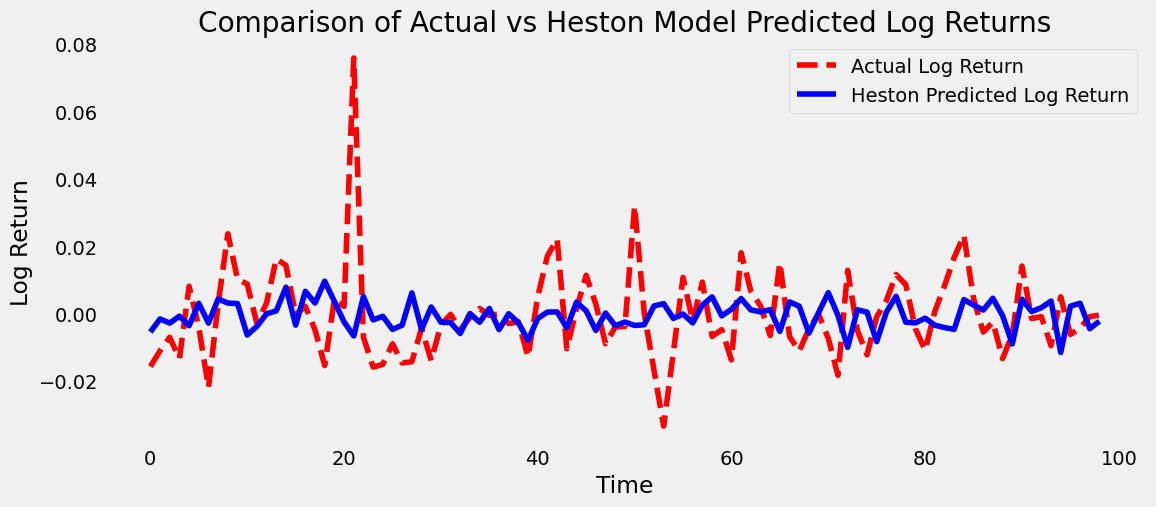

,Actual Return,Predicted Return Heston
0,-0.015701,-0.005448
1,-0.011010,-0.001577
2,-0.007006,-0.002796
3,-0.013315,-0.000739
4,0.008134,-0.003583
...,...,...
94,0.004995,-0.011506
95,-0.006174,0.002214
96,-0.004285,0.003085
97,-0.000877,-0.004458


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from scipy.optimize import minimize

# استفاده از داده‌های بازدهی لگاریتمی مدل GRU
returns = returndata.values

# تقسیم داده‌ها به 90٪ آموزش و 10٪ تست
split_percentage = 0.9
n_train = int(len(returns) * split_percentage)
train_data = returns[:n_train]
test_data = returns[n_train:]

# مدل هستون برای پیش‌بینی نوسانات
def heston_log_likelihood(params, returns):
    kappa, theta, sigma, v0, rho = params
    n = len(returns)
    v = np.zeros(n)
    v[0] = max(v0, 1e-8)  # جلوگیری از مقدار منفی یا صفر
    log_likelihood = 0

    for t in range(1, n):
        v[t] = max(v[t-1] + kappa * (theta - v[t-1]) + sigma * sqrt(max(v[t-1], 1e-8)) * np.random.normal(), 1e-8)
        log_likelihood += -0.5 * (np.log(v[t]) + (returns[t] ** 2) / v[t])

    return -log_likelihood

# مقداردهی اولیه پارامترهای مدل هستون
initial_params = [0.1, 0.02, 0.1, 0.02, 0.5]
result = minimize(heston_log_likelihood, initial_params, args=(train_data,), method='Nelder-Mead')
kappa, theta, sigma, v0, rho = result.x

# شبیه‌سازی مسیرهای آینده با مدل هستون
simulations = 1000
future_days = len(test_data)

simulated_returns = np.zeros((simulations, future_days))

for i in range(simulations):
    v = v0
    for t in range(future_days):
        v = max(v + kappa * (theta - v) + sigma * sqrt(max(v, 1e-8)) * np.random.normal(), 1e-8)
        simulated_returns[i, t] = np.random.normal(0, sqrt(v))

# محاسبه میانگین بازدهی پیش‌بینی‌شده
predicted_returns = simulated_returns.mean(axis=0)

# تبدیل داده‌های تست به DataFrame برای نمایش بهتر
test_df = pd.DataFrame(index=range(len(test_data)))
test_df['Actual Return'] = test_data
test_df['Predicted Return Heston'] = predicted_returns

# رسم نمودار مقایسه‌ای بین مدل هستون و GRU
plt.figure(figsize=(12, 5))
plt.plot(test_df.index, test_df['Actual Return'], label='Actual Log Return', color='red', linestyle='dashed')
plt.plot(test_df.index, test_df['Predicted Return Heston'], label='Heston Predicted Log Return', color='blue')
plt.title('Comparison of Actual vs Heston Model Predicted Log Returns')
plt.xlabel('Time')
plt.ylabel('Log Return')
plt.legend()
plt.grid()
plt.show()

# نمایش مقایسه نهایی
test_df[['Actual Return', 'Predicted Return Heston']]


In [19]:
# نمایش ضرایب بهینه‌شده
print("ضرایب بهینه‌شده:")
print(f"kappa: {kappa}")
print(f"theta: {theta}")
print(f"sigma: {sigma}")
print(f"v0: {v0}")
print(f"rho: {rho}")

# نمایش نمودارها
plt.tight_layout()
plt.show()

ضرایب بهینه‌شده:
kappa: 0.09830066578400004
theta: 0.0207443330288
sigma: 0.09873698204
v0: 0.02047641982879999
rho: 0.5129645757199999


<Figure size 640x480 with 0 Axes>

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# محاسبه MSE
mse = mean_squared_error(test_df['Actual Return'], test_df['Predicted Return Heston'])

# محاسبه MAE
mae = mean_absolute_error(test_df['Actual Return'], test_df['Predicted Return Heston'])

# محاسبه RMSE
rmse = sqrt(mse)

# نمایش نتایج
print(f'MSE: {mse:.6f}')
print(f'MAE: {mae:.6f}')
print(f'RMSE: {rmse:.6f}')


MSE: 0.000203
MAE: 0.009754
RMSE: 0.014237


pandas.core.series.Series

In [22]:
import numpy as np

# تبدیل به آرایه numpy
predicted_returns = test_df['Predicted Return Heston'].to_numpy()

# بررسی ابعاد قبل از تغییر
print("Shape before reshaping:", predicted_returns.shape)

# تغییر ابعاد به (99, 1)
predicted_returns = predicted_returns.reshape(-1, 1)

# بررسی ابعاد پس از تغییر
print("Shape after reshaping:", predicted_returns.shape)


Shape before reshaping: (99,)
Shape after reshaping: (99, 1)


In [24]:
predict_gru.shape , predicted_returns.shape , y_test.shape

((99, 1), (99, 1), (99, 1))

In [25]:
pip install pyswarm

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4463 sha256=4f99b6600e7eec855194b94d6d296f2d871a70911ed6d4949c1e0de427794664
  Stored in directory: /root/.cache/pip/wheels/bb/4f/ec/8970b83323e16aa95034da175454843947376614d6d5e9627f
Successfully built pyswarm


In [26]:
import numpy as np
from pyswarm import pso

# داده‌های فرضی (شما باید این‌ها را با داده‌های واقعی خود جایگزین کنید)
# اطمینان از تبدیل آرایه‌ها به بردارهای 1-بعدی
predicted_prices = predict_gru.flatten()  # تبدیل به بردار 1-بعدی
closest_simulated_path = predicted_returns.flatten()  # تبدیل به آرایه numpy و سپس flatten
real_data = y_test.flatten()  # داده واقعی نیز به بردار 1-بعدی تبدیل شود

# تعداد روزها
n_days = len(real_data)

# تعریف تابع هدف
def objective_function(weights):
    """
    تابع هدف: کمینه‌سازی خطای پیش‌بینی ترکیبی.
    weights: آرایه‌ای از وزن‌ها به شکل [w1_1, w2_1, w1_2, w2_2, ..., w1_n, w2_n]
    """
    # تبدیل آرایه وزن‌ها به ماتریس ضرایب
    weights_matrix = weights.reshape(n_days, 2)
    # ترکیب پیش‌بینی‌ها با وزن‌ها برای هر روز
    combined_predictions = np.sum(weights_matrix * np.column_stack((predicted_prices, closest_simulated_path)), axis=1)
    # محاسبه خطای MSE
    mse = np.mean((real_data - combined_predictions) ** 2)
    return mse

# محدوده وزن‌ها (بدون محدودیت خاصی)
# برای هر روز دو وزن داریم (w1_i, w2_i)
lb = [-1] * (2 * n_days)  # lower bounds (می‌توانید این مقادیر را تغییر دهید)
ub = [1] * (2 * n_days)  # upper bounds (می‌توانید این مقادیر را تغییر دهید)

# اجرای الگوریتم PSO (بدون محدودیت)
optimal_weights, optimal_mse = pso(objective_function, lb, ub)

# تبدیل وزن‌های بهینه به ماتریس ضرایب
optimal_weights_matrix = optimal_weights.reshape(n_days, 2)

# نمایش نتایج
print("Optimal Weights Matrix (PSO):")
print(optimal_weights_matrix)
print("Optimal MSE:", optimal_mse)

# ترکیب پیش‌بینی‌ها با وزن‌های بهینه برای هر روز
final_predictions = np.sum(optimal_weights_matrix * np.column_stack((predicted_prices, closest_simulated_path)), axis=1)

# محاسبه خطاهای نهایی
final_mse = np.mean((real_data - final_predictions) ** 2)
final_rmse = np.sqrt(final_mse)
final_mae = np.mean(np.abs(real_data - final_predictions))

print("Final MSE:", final_mse)
print("Final RMSE:", final_rmse)
print("Final MAE:", final_mae)

Stopping search: Swarm best objective change less than 1e-08
Optimal Weights Matrix (PSO):
[[ 1.          1.        ]
 [-0.08158036  0.9104023 ]
 [ 0.53674058  0.6469732 ]
 [-0.09572454  0.47796517]
 [-0.49611054 -0.67451559]
 [-0.48106515 -0.30696574]
 [-0.07423082  1.        ]
 [-0.73977501  0.79036933]
 [ 0.0609787  -0.26131078]
 [ 0.85629809 -1.        ]
 [ 0.98850457 -0.35967245]
 [ 1.         -0.32250667]
 [ 0.56815549 -1.        ]
 [ 0.52262203  0.51539475]
 [ 0.72248314  1.        ]
 [-0.74920554 -0.39462123]
 [ 0.8415704  -0.11458704]
 [ 0.66958531 -0.30831917]
 [ 1.         -1.        ]
 [ 0.63273924  0.20086776]
 [ 0.42752638  0.85830184]
 [-0.9317915  -1.        ]
 [ 0.38719774 -0.99710885]
 [-0.3143712   0.57967434]
 [ 0.98577559  0.32774971]
 [ 0.44571658  0.78060349]
 [-0.66664632  0.99892143]
 [ 0.94192116 -0.3566414 ]
 [ 0.08715818  0.14587287]
 [ 0.63511723  0.24915269]
 [ 0.33355536 -0.11946964]
 [-0.7984769  -0.8849265 ]
 [-0.09117752  0.03886698]
 [-0.40136876  0.3

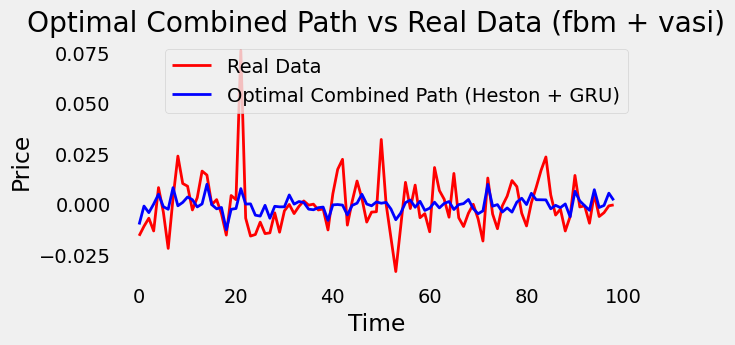

In [27]:
# رسم نمودار
plt.figure(figsize=(6, 3))
plt.plot(real_data, lw=2, color='red', label='Real Data')
plt.plot(final_predictions, lw=2, color='blue', label='Optimal Combined Path (Heston + GRU)')
plt.title("Optimal Combined Path vs Real Data (fbm + vasi)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

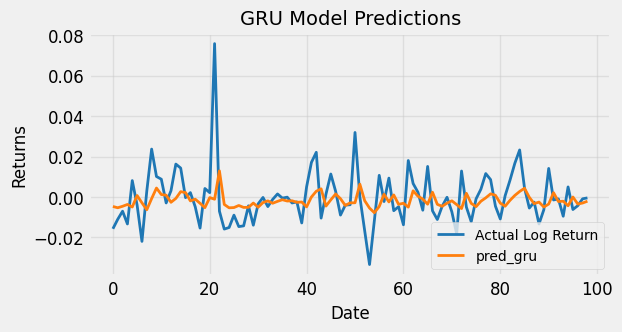

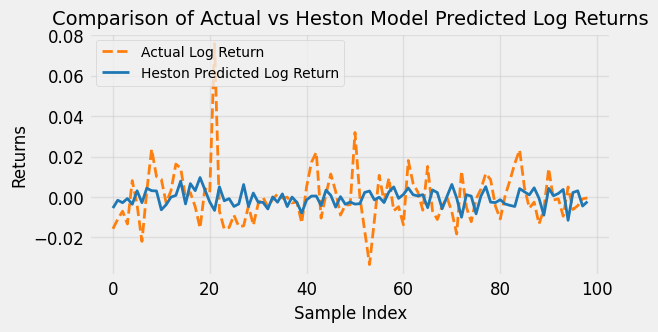

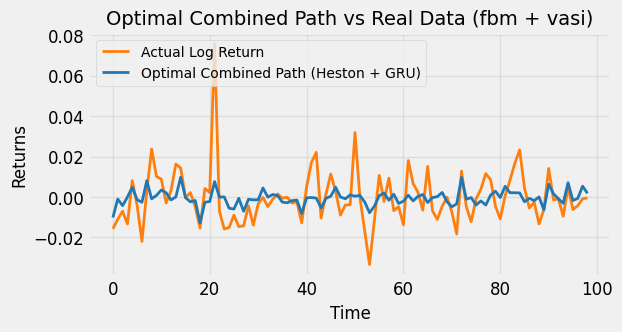

In [28]:
import matplotlib.pyplot as plt

# تنظیمات عمومی برای تمام نمودارها
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 14, 'axes.labelsize': 12, 'lines.linewidth': 2, 'grid.alpha': 0.5})

# نمودار اول: پیش‌بینی‌ها
plt.figure(figsize=(6, 3))
plt.plot(y_test, color='#1f77b4', label='Actual Log Return')  # رنگ مشابه (آبی)
plt.plot(predict_gru, color='#ff7f0e', label='pred_gru')  # رنگ مشابه (نارنجی)
plt.legend(loc='lower right', fontsize=10)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('GRU Model Predictions')
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(range(len(test_df)), test_df['Actual Return'], label='Actual Log Return', color='#ff7f0e', linestyle='--')  # محور x بر اساس تعداد نمونه‌ها
plt.plot(range(len(test_df)), test_df['Predicted Return Heston'], label='Heston Predicted Log Return', color='#1f77b4')
plt.title('Comparison of Actual vs Heston Model Predicted Log Returns')
plt.xlabel('Sample Index')  # تغییر نام محور x
plt.ylabel('Returns')
plt.legend(loc='upper left', fontsize=10)
plt.grid(True)
plt.show()


# نمودار سوم: مقایسه داده‌های واقعی با مسیر بهینه ترکیب‌شده
plt.figure(figsize=(6, 3))
plt.plot(real_data, lw=2, color='#ff7f0e', label='Actual Log Return')  # رنگ مشابه (نارنجی)
plt.plot(final_predictions, lw=2, color='#1f77b4', label='Optimal Combined Path (Heston + GRU)')  # رنگ مشابه (آبی)
plt.title("Optimal Combined Path vs Real Data (fbm + vasi)")
plt.xlabel("Time")
plt.ylabel("Returns")
plt.legend(loc='upper left', fontsize=10)
plt.grid(True)
plt.show()

